WRF RESULTS PROCESSING: MOVING NESTS

The following script takes as an input the output files of a WRF nested real run (i.e. *wrfout_d02, wrfout_d03* etc.)
and produces plots that demonstrate key indicators of its performance in simulating a cyclone. 
It is a simplified version of the *'plot_wrfout_do1.ipynb'* script but can handle the shifting positions of moving nests.

    Sea-level pressure & 10m windspeed
    Geopotential (gph) height and winds at the gph
    Cloud top temperatures
    Absolute vorticity
    Maximum wind speeds

The user needs to go to the 'user inputs' section and enter all the information required. 

This script requires the installation of the wrf-python library (among others)

    pip install --user wrf-python

This script is written in Jan. 2019 by Chad Burton.
The notebook was completed as a part of a graduate program at Geoscience Australia.


### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4
import cartopy
import pandas as pd
import wrf
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import COLORS
from cartopy.feature import NaturalEarthFeature
import cartopy.io.shapereader as shpreader
from wrf import to_np, getvar, smooth2d, GeoBounds, get_cartopy, cartopy_xlim
from wrf import cartopy_ylim, latlon_coords, get_basemap, interplevel, CoordPair
from wrf import vertcross, xy_to_ll, ll_to_xy
import geopandas as gpd

## User Inputs

In [2]:
#where is the data (ie wrfout_d0*)?
ncfile_path = "data/nudging_runs/alby_nudge36high_3dom_0204_1200/wrfout_d02_1978-04-02_12:00:00"

#What is the domain identfier? ie d02, d03?
domainID = 'd02'

#which time slice do you want (FORMAT MUST BE: '1978-04-05T00:00') 
time = '1978-04-04T18:00'

#what pressure (in hPa) do you wish to see the geopoential height, windspeed and vorticity?
gph_pressure = 500

# Should I export the results and where?
export = False
results_path = "results/nudging_runs/alby_nudge36high_3dom_0204_1200/"

## Useful stuff for script

In [3]:
#getting time data from a variable to use for labelling plots
#This means the user can enter a time of interest rather
#than an index integer - more intuitive.
#grabbing any variable that will load reasaonably quickly
ncfile = netCDF4.Dataset(ncfile_path)
p = getvar(ncfile, "pressure", timeidx=wrf.ALL_TIMES, method="cat")

#getting the time dimension
times=[]
for i in range(0, len(p.Time)):
    x = str(p.Time[i].values)[:16]
    times.append(x)

#convert the time strings into indexes for slicing later
time_slice = times.index(time)

def plot_towns(ax, lats, lons, resolution='10m', transform=crs.PlateCarree(), zorder=3):
    """
    This function will download the 'populated_places' shapefile from
    NaturalEarth, trim the shapefile based on the limits of the provided
    lat, long coords, and then plot the locations and names of the towns
    on a given GeoAxes.
    ax = a pyplot axes object
    lats = latitudes, as an xarray object
    lons = longitudes, as an xarray object
    resolution= str. either '10m' or '50m'
    transform = a cartopy crs object
    """
    #get town locations
    shp_fn = shpreader.natural_earth(resolution=resolution, category='cultural', name='populated_places')
    shp = shpreader.Reader(shp_fn)
    xy = [pt.coords[0] for pt in shp.geometries()]
    x, y = list(zip(*xy))

    #get town names
    towns = shp.records()
    names_en = []
    for town in towns:
        names = town.attributes['name_en']
        names_en.append(names)

    #create data frame and index by the region of the plot
    all_towns = pd.DataFrame({'names_en': names_en, 'x':x, 'y':y})
    region_towns = all_towns[(all_towns.y<np.max(lats.values)) & (all_towns.y>np.min(lats.values))
                           & (all_towns.x>np.min(lons.values)) & (all_towns.x<np.max(lons.values))]

    #plot the locations and labels of the towns in the region
    ax.scatter(region_towns.x.values, region_towns.y.values, c ='black', marker= '.', transform=transform, zorder=zorder)
    transform_mpl = crs.PlateCarree()._as_mpl_transform(ax) #this is a work-around to transform xy coords in ax.annotate
    for i, txt in enumerate(region_towns.names_en):
         ax.annotate(txt[:3], (region_towns.x.values[i], region_towns.y.values[i]), xycoords=transform_mpl)

## Sea Level Pressure & 10m Wind Speed

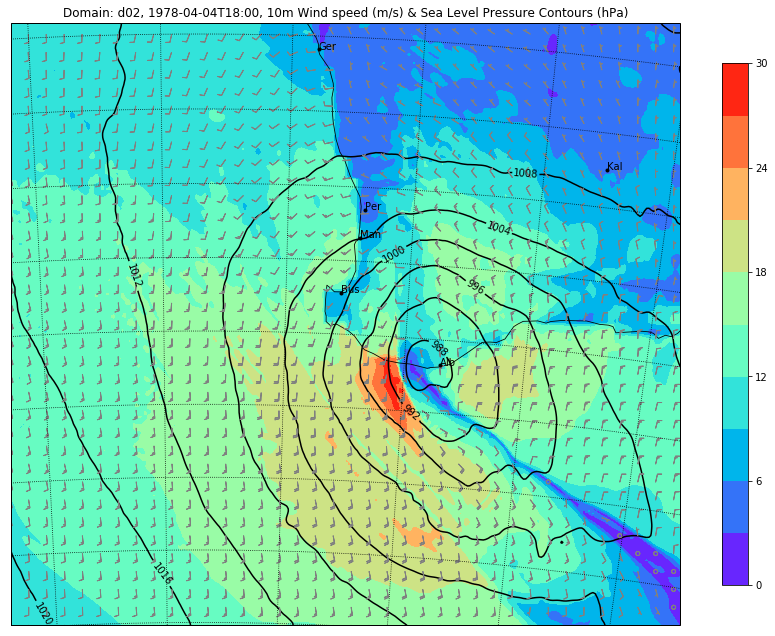

In [ ]:
#Create sea level pressure and plot sea level pressure for a time slice
ncfile = netCDF4.Dataset(ncfile_path)
# Get the Sea Level Pressure
slp = wrf.getvar(ncfile, "slp", timeidx=wrf.ALL_TIMES, method="cat")
slp = slp[time_slice]
# Smooth the sea level pressure since it tends to be noisy near the mountains
smooth_slp = smooth2d(slp, 3)

#get wind speed and components
wspd = getvar(ncfile, "uvmet10_wspd_wdir", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")[0,:]
wspd = wspd[time_slice]

u10 = getvar(ncfile, "uvmet10", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")[0,:]
u10 = u10[time_slice]

v10 = getvar(ncfile, "uvmet10", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")[1,:]
v10 = v10[time_slice]

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)
# Get the cartopy mapping object
cart_proj = get_cartopy(slp)
# Create a figure
fig = plt.figure(figsize=(15,12))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)
# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')

ax.add_feature(states, linewidth=.5)
ax.coastlines('50m', linewidth=0.8)

#add towns
plot_towns(ax, lats, lons, '50m')

# Make the contour outlines for the smoothed sea level pressure.
contours = plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp), 10, colors="black",
            transform=crs.PlateCarree())
plt.clabel(contours, inline=1, fontsize=10, fmt="%i")
# Add the wind speed contours
plt.contourf(to_np(lons), to_np(lats), to_np(wspd), 10, transform=crs.PlateCarree(),
             cmap=get_cmap("rainbow"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.8)

#Add wind barbs, only plotting every 15th data point.
barbNo=8
ax.barbs(to_np(lons[::barbNo,::barbNo]), to_np(lats[::barbNo,::barbNo]),
         to_np(u10[::barbNo,::barbNo]),to_np(v10[::barbNo,::barbNo]), sizes=dict(emptybarb=0.25, spacing=0.2, height=0.5),
         transform=crs.PlateCarree(), barbcolor='grey', length=4, zorder=2)

# Set the map limits
ax.set_xlim(cartopy_xlim(smooth_slp))
ax.set_ylim(cartopy_ylim(smooth_slp))
# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")
plt.title("Domain: " + domainID + ", " + time + ", " + "10m Wind speed (m/s) & Sea Level Pressure Contours (hPa)")

if export == True:
    plt.savefig(results_path + domainID + "_10mWS_SLP_" + time + ".pdf", bbox_inches='tight')

## Geopotential Height and Wind Speed

In [ ]:
# Extract the pressure, geopotential height, and wind variables
ncfile = netCDF4.Dataset(ncfile_path)

p = getvar(ncfile, "pressure", timeidx=wrf.ALL_TIMES, method="cat")
z = getvar(ncfile, "z", timeidx=wrf.ALL_TIMES, method="cat")
ua = getvar(ncfile, "ua", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")
va = getvar(ncfile, "va", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")
wspd = getvar(ncfile, "wspd_wdir", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")[0,:]

# Interpolate geopotential height, u, and v winds to 500 hPa
ht_500 = interplevel(z[time_slice], p[time_slice], gph_pressure)
u_500 = interplevel(ua[time_slice], p[time_slice], gph_pressure)
v_500 = interplevel(va[time_slice], p[time_slice], gph_pressure)
wspd_500 = interplevel(wspd[time_slice], p[time_slice], gph_pressure)

In [ ]:
# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_500)

# Get the basemap object
cart_proj = get_cartopy(ht_500)

# Create the figure
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection=cart_proj)

# Add the 500 hPa geopotential height contours
contours = plt.contour(to_np(lons), to_np(lats), to_np(ht_500),
                       colors="black", transform=crs.PlateCarree())
ax.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the wind speed contours
levels = [10, 15, 20, 25, 30, 35, 40, 50, 60]
wspd_contours = ax.contourf(to_np(lons), to_np(lats), to_np(wspd_500), levels=levels,
                            cmap=get_cmap("rainbow"), transform=crs.PlateCarree())
plt.colorbar(wspd_contours, ax=ax, pad=.05, shrink=0.7)

# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
ax.add_feature(states, linewidth=.5)
ax.coastlines('50m', linewidth=0.8)

# Add the 500 hPa wind barbs, only plotting every nth data point.
barbNo=8
ax.barbs(to_np(lons[::barbNo,::barbNo]), to_np(lats[::barbNo,::barbNo]), to_np(u_500[::barbNo, ::barbNo]),
         to_np(v_500[::barbNo, ::barbNo]), transform=crs.PlateCarree(), length=5, barbcolor='grey', zorder=3)

# Set the map limits
ax.set_xlim(cartopy_xlim(ht_500))
ax.set_ylim(cartopy_ylim(ht_500))

plt.title("Domain: " + domainID + ", " + time + " " + str(gph_pressure)
                  + " hPa Height (m), Wind Speed (m s-1), Barbs (m s-1)")

if export == True:
    plt.savefig(results_path + "GeoPotHeight_Windspeed_" + time + ".pdf", bbox_inches='tight')

## Cloud top temperatures

In [ ]:
ncfile = netCDF4.Dataset(ncfile_path)

# Get the WRF variables
slp = getvar(ncfile, "slp", timeidx=wrf.ALL_TIMES, method="cat")
slp=slp[time_slice]
smooth_slp = smooth2d(slp, 3)
ctt = getvar(ncfile, "ctt", timeidx=wrf.ALL_TIMES, method="cat")
ctt = ctt[time_slice]

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Create the figure
fig = plt.figure(figsize=(15,12))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
land = NaturalEarthFeature(category='physical', name='land', scale='50m',
                                    facecolor=COLORS['land'])
ocean = NaturalEarthFeature(category='physical', name='ocean',scale='50m',
                                     facecolor=COLORS['water'])

# Make the pressure contours
contour_levels = [960, 965, 970, 975, 980, 990, 995, 1000, 1005]
c1 = ax.contour(to_np(lons), to_np(lats), to_np(smooth_slp), levels=contour_levels, colors="white",
                zorder=3, linewidths=1.0)

# Create the filled cloud top temperature contours
contour_levels = [-80.0, -70.0, -60, -50, -40, -30, -20, -10, 0, 10]
ctt_contours = ax.contourf(to_np(lons), to_np(lats), to_np(ctt), contour_levels, cmap=get_cmap("Greys"),
                           transform=crs.PlateCarree(), zorder=2)

# Create the color bar for cloud top temperature
cb_ctt = fig.colorbar(ctt_contours, ax=ax, shrink=0.7)
cb_ctt.ax.tick_params(labelsize=10)

# Draw the oceans, land, and states, gridlines
ax.add_feature(states, linewidth=.5, zorder=2)
ax.add_feature(land)
ax.add_feature(ocean)
ax.coastlines('50m', linewidth=0.8, zorder=2)
ax.gridlines(color="white", linestyle="dotted")

# Add titles
ax.set_title("Domain: " + domainID + ", " + time + " Cloud Top Temperature (degC)", {"fontsize" : 16})

if export == True:
    plt.savefig(results_path + domainID +  "_CTT_VertWS_" + str(time) + ".pdf", bbox_inches='tight')

## Storm Vorticity

In [ ]:
ncfile = netCDF4.Dataset(ncfile_path)
#extract absolute vorticity
avo = getvar(ncfile, "avo", timeidx=wrf.ALL_TIMES, method="cat")
avo = avo[time_slice]
# Extract the Pressure (hPa) fields
p = getvar(ncfile, "pressure", timeidx=wrf.ALL_TIMES, method="cat")
p = p[time_slice]
#extract height
z = getvar(ncfile, "z", timeidx=wrf.ALL_TIMES, method="cat")
z = z[time_slice]
#wind components
ua = getvar(ncfile, "ua", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")
ua = ua[time_slice]
va = getvar(ncfile, "va", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")
va= va[time_slice]

# Compute the absolute vorticity, u, v, and gph at 500hPa
avo_500 = interplevel(avo, p, gph_pressure)
ht_500 = interplevel(z, p, gph_pressure)
u_500 = interplevel(ua, p, gph_pressure)
v_500 = interplevel(va, p, gph_pressure)

In [ ]:
# Get the latitude and longitude points
lats, lons = latlon_coords(avo_500)
# Get the cartopy mapping object
cart_proj = get_cartopy(avo_500)
# Create a figure
fig = plt.figure(figsize=(15,12))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)
# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
ax.add_feature(states, linewidth=.5)
ax.coastlines('50m', linewidth=0.8)

# Add the 500 hPa geopotential height contours
contours = plt.contour(to_np(lons), to_np(lats), to_np(ht_500), colors="black",
            transform=crs.PlateCarree())
plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the vorticity
plt.contourf(to_np(lons), to_np(lats), to_np(avo_500), transform=crs.PlateCarree(),
             cmap=get_cmap("bwr"), vmin=-30, vmax=30)

#create a colorbar
sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-30, vmax=30))
sm._A = []
plt.colorbar(sm, shrink=0.7)

# Add the 500 hPa wind barbs, only plotting every 25th data point.
barbNo=8
plt.barbs(to_np(lons[::barbNo,::barbNo]), to_np(lats[::barbNo,::barbNo]), to_np(u_500[::barbNo, ::barbNo]),
         to_np(v_500[::barbNo, ::barbNo]), transform=crs.PlateCarree(), length=4,barbcolor='grey')

# Set the map limits
ax.set_xlim(cartopy_xlim(avo_500))
ax.set_ylim(cartopy_ylim(avo_500))
# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")
plt.title("Domain: " + domainID + ", " + time + ", " + "Absolute Vorticity (10-5 s-1) & "
                                      + str(gph_pressure) + " hPa Height contours (m)")

if export == True:
    plt.savefig(results_path + domainID + "_absolute_vorticity_" + time + ".pdf", bbox_inches='tight')

## Maximum 10m wind speeds

In [ ]:
ncfile = netCDF4.Dataset(ncfile_path)

max10ws = wrf.getvar(ncfile, "WSPD10MAX", timeidx=wrf.ALL_TIMES, method="cat")
max10ws = max10ws[time_slice]

# Get the latitude and longitude points
lats, lons = latlon_coords(max10ws)
# Get the cartopy mapping object
cart_proj = get_cartopy(max10ws)
# Create a figure
fig = plt.figure(figsize=(15,12))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)
# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')

#add towns
plot_towns(ax, lats, lons)

#add the states and coastline
ax.add_feature(states, linewidth=.5)
ax.coastlines('50m', linewidth=0.8)

# Add the max wind speed contours
plt.contourf(to_np(lons), to_np(lats), to_np(max10ws), 10, transform=crs.PlateCarree(),
             cmap=get_cmap("rainbow"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.8)

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

# Set the map limits
ax.set_xlim(cartopy_xlim(max10ws))
ax.set_ylim(cartopy_ylim(max10ws))

plt.title("Domain: " + domainID + ", " + time + ", " + "10m Max. Wind speed (m/s)")

if export == True:
    plt.savefig(results_path + domainID + "_10m_MaxWS_" + time + ".pdf", bbox_inches='tight')